In [422]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb

In [423]:
pd.options.mode.chained_assignment = None 

## Loading datasets

In [424]:
train_df = pd.read_csv('dataset/train.csv')
X_test = pd.read_csv('dataset/test.csv')

In [425]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [426]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [427]:
# includes creating a new feature "family size" and dropping useless columns

def preprocessor(df):
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    df['Family size'] = df['SibSp']+df['Parch']+1
    df.drop(['Parch', 'SibSp'], axis=1, inplace=True)

    return df

In [428]:
preprocessor(train_df)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family size
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1
...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,1
887,1,1,female,19.0,30.0000,S,1
888,0,3,female,NaN,23.4500,S,4
889,1,1,male,26.0,30.0000,C,1


## Some info about the dataset

In [429]:
# some barplots to see how the dataset looks like

def bar_visualizer(df):
    plot = sns.barplot(x=df[df.columns[0]],
                       y=df[df.columns[1]], palette='muted')
    for bar in plot.patches:
        plot.annotate(format(bar.get_height(), 'g'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                      size=12, xytext=(0, 4),
                      textcoords='offset points')

In [430]:
temp = train_df[['Sex', 'Survived']].groupby(
    'Sex', as_index=False)['Survived'].sum()

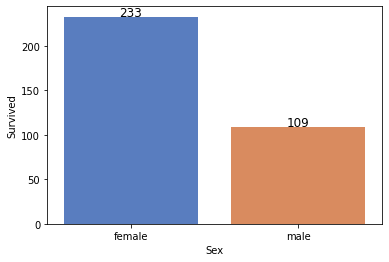

In [431]:
bar_visualizer(temp)

In [432]:
temp = train_df[['Pclass', 'Survived']].groupby(
    'Pclass', as_index=False)['Survived'].sum()
temp

,Pclass,Survived
0,1,136
1,2,87
2,3,119


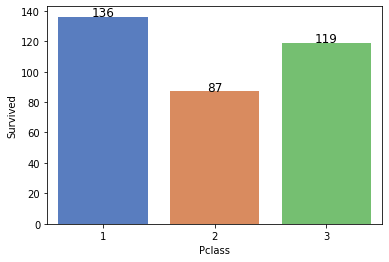

In [433]:
bar_visualizer(temp)

In [434]:
temp = train_df[['Embarked', 'Survived']].groupby(
    'Embarked', as_index=False)['Survived'].sum()

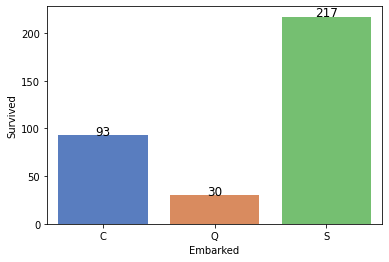

In [435]:
bar_visualizer(temp)

In [436]:
temp = train_df[['Survived', 'Family size']].groupby(
    'Family size', as_index=False)['Survived'].sum()

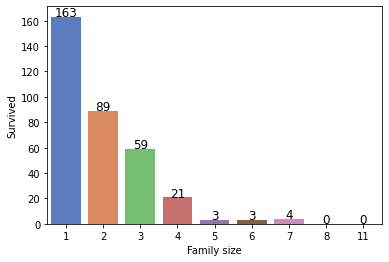

In [437]:
bar_visualizer(temp)

In [438]:
temp = train_df[['Survived', 'Age']].groupby(
    'Survived', as_index=False)['Age'].mean()
temp

,Survived,Age
0,0,30.626179
1,1,28.343690


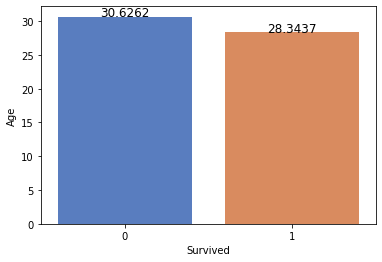

In [439]:
bar_visualizer(temp)

## Checking missing values

In [440]:
train_df.isna().sum()

Survived         0
Pclass           0
Sex              0
Age            177
Fare             0
Embarked         2
Family size      0
dtype: int64

In [441]:
# there are just two of missing values in this column, we can easily drop them.

train_df.dropna(subset=['Embarked'], inplace=True)

### Label encoder

In [442]:
le = LabelEncoder()
for col in ['Embarked', 'Sex']:
    train_df[col] = le.fit_transform(train_df[col])

Sex: 1 male, 0 female <br>
Embarked: 2 S, 0 C, 1 Q

### Data correlation

<AxesSubplot:>

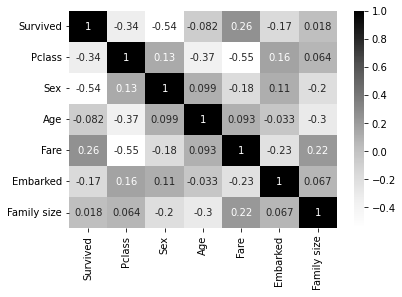

In [443]:
sns.heatmap(train_df.corr(), cmap='Greys', annot=True)

## Train and Validation split

In [444]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X

,Pclass,Sex,Age,Fare,Embarked,Family size
0,3,1,22.0,7.2500,2,2
1,1,0,38.0,71.2833,0,2
2,3,0,26.0,7.9250,2,1
3,1,0,35.0,53.1000,2,2
4,3,1,35.0,8.0500,2,1
...,...,...,...,...,...,...
886,2,1,27.0,13.0000,2,1
887,1,0,19.0,30.0000,2,1
888,3,0,NaN,23.4500,2,4
889,1,1,26.0,30.0000,0,1


In [445]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [446]:
X_train

,Pclass,Sex,Age,Fare,Embarked,Family size
708,1,0,22.0,151.5500,2,1
240,3,0,NaN,14.4542,0,2
382,3,1,32.0,7.9250,2,1
792,3,0,NaN,69.5500,2,11
683,3,1,14.0,46.9000,2,8
...,...,...,...,...,...,...
107,3,1,NaN,7.7750,2,1
271,3,1,25.0,0.0000,2,1
862,1,0,48.0,25.9292,2,1
436,3,0,21.0,34.3750,2,5


## Taking care of missing values

### Train set

In [447]:
# replacing NaNs in age column by mean value of this column

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[['Age']] = imputer.fit(X_train[['Age']]).transform(X_train[['Age']])

### Validation set

In [448]:
# replacing NaNs in age column by mean value of this column

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_val[['Age']] = imputer.fit(X_val[['Age']]).transform(X_val[['Age']])

## Training a model

### Decision Tree

In [449]:
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [450]:
print(accuracy(y_val, y_pred))

0.7415730337078652


### Random Forest

In [451]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [452]:
print(accuracy(y_pred, y_val))

0.7808988764044944


### KNN

In [453]:
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [454]:
print(accuracy(y_val, y_pred))

0.6966292134831461


### SVM

In [455]:
classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [456]:
print(accuracy(y_val, y_pred))

0.6797752808988764


### Logistic Regression

In [457]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [458]:
print(accuracy(y_val, y_pred))

0.7808988764044944


## Classification report

In [459]:
# classification report of logistic regression model

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       109
           1       0.70      0.77      0.73        69

    accuracy                           0.78       178
   macro avg       0.77      0.78      0.77       178
weighted avg       0.79      0.78      0.78       178



## Confusion matrix

In [460]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[86, 23],
       [16, 53]])

## Preparing the test set

In [463]:
X_test = preprocessor(X_test)

### Label encoder

In [464]:
le = LabelEncoder()
for col in ['Embarked', 'Sex']:
    X_test[col] = le.fit_transform(X_test[col])

In [465]:
X_test.isna().sum()

Pclass          0
Sex             0
Age            86
Fare            1
Embarked        0
Family size     0
dtype: int64

In [466]:
X_test[['Age']] = imputer.fit(X_test[['Age']]).transform(X_test[['Age']])
X_test[['Fare']] = imputer.fit(X_test[['Fare']]).transform(X_test[['Fare']])

## Predicting results for the test set

### Logistic Regression

In [467]:
y_pred = classifier.predict(X_test)

In [472]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,